In [1]:
using Random
using BSON

In [2]:
include("../../src/NNSurrogate.jl")
include("../../src/NNJuMP.jl")
include("../../src/NNGogeta.jl")
include("../../src/MCDropout.jl")

generate_resample_configs_mc (generic function with 1 method)

# Auto-thermal Reformer Process
2 input variables, 12 outputs of interest

In [3]:
Random.seed!(101)

TaskLocalRNG()

Pre-acquired simulated data points from [reformer.csv](https://github.com/cog-imperial/OMLT/blob/dfe44bd59232996d821d9f8eb6d1b8f2d8aa1c3a/docs/notebooks/data/reformer.csv)

In [4]:
root = dirname(@__FILE__)
csv_file_path = joinpath(root, "data/reformer.csv")
rdata = DataFrame(CSV.File(csv_file_path, header=true))
x = Matrix(rdata[:, 1:2])'
y = Matrix(rdata[:, 3:end-1])'
x_lb = minimum(x, dims=2)
x_ub = maximum(x, dims=2)
full_indices = 1:size(x, 2)
mean_total = mean(x, dims=2)
std_total = std(x, dims=2)

2×1 Matrix{Float64}:
 0.20501687640880104
 0.11700042517196035

# Initial training

In [5]:
# randomly select 1000 data points
selected_indices = randperm(size(x, 2))[1:1000]
# store the not selected data points for later use
complement_indices = setdiff(full_indices, selected_indices)

x_init = x[:, selected_indices]
y_init = y[:, selected_indices]
mean_init = mean(x_init, dims=2)
std_init = std(x_init, dims=2)
data_reformer = create_nn_data(x_init, y_init)

NN_Data(Float32[0.78985506 0.8 … 0.15072463 0.2826087; 0.95789474 1.0842105 … 0.9157895 0.84210527], Float32[0.24394378 0.26278263 … 0.94253445 0.73210865; 10736.503 10890.6045 … 32942.22 26885.426; … ; 0.08385974 0.09072844 … 0.12592867 0.114265196; 0.22776727 0.22006018 … 0.347762 0.3407374], Float32[0.37391305 0.29275364 … 0.24202898 0.6173913; 1.0842105 1.0736842 … 1.0631579 0.8947368], Float32[0.8226239 0.92023844 … 0.9765701 0.4148616; 27057.316 30186.145 … 32064.402 15901.807; … ; 0.13477153 0.13734406 … 0.13821818 0.101041354; 0.31943908 0.32811326 … 0.33304155 0.28777304])

In [6]:
# define the lower and upper bounds for the input variables
L_bounds_init = [x_lb[1], x_lb[2]]
U_bounds_init = [x_ub[1], x_ub[2]]
sampling_config_init = Sampling_Config(1000, L_bounds_init, U_bounds_init)

Sampling_Config(1000, [0.1, 0.8], [0.8, 1.2])

In [7]:
# normalise the data, including the outputs
data_reformer_norm, mean_init, std_init, mean_init_y, std_init_y = normalise_data(data_reformer, true)

sampling_config_init_norm = Sampling_Config(
    sampling_config_init.n_samples,
    (sampling_config_init.lb .- vec(mean_init)) ./ vec(std_init),
    (sampling_config_init.ub .- vec(mean_init)) ./ vec(std_init)
)

Sampling_Config(1000, [-1.6749027214211745, -1.7377128564223425], [1.6711431088644686, 1.6867999851760118])

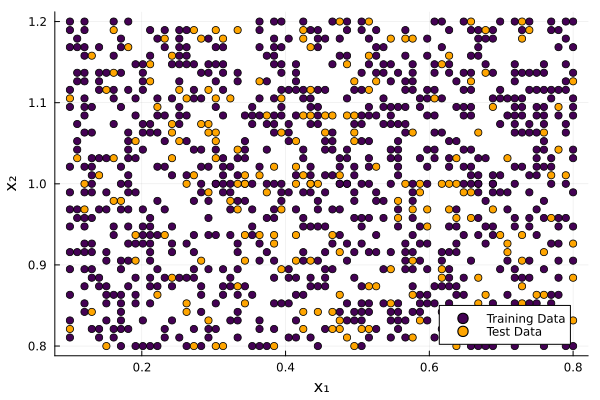

In [8]:
Plots.scatter(data_reformer.x_train[1, :], data_reformer.x_train[2, :], color = :viridis, xlabel="x₁", ylabel="x₂", legend=:bottomright, label="Training Data")
Plots.scatter!(data_reformer.x_test[1, :], data_reformer.x_test[2, :], color = :orange, legend=:bottomright, label="Test Data")

In [8]:
# train the surrogate model
config_reformer = NN_Config([2,10,10,10,10,12], [relu, relu, relu, relu, identity], false, 0, 0.0, Adam(0.001, (0.9, 0.999), 1e-07), 1, 800, 100, 0)
train_time = @elapsed result_reformer = NN_train(data_reformer_norm, config_reformer)
NN_results(config_reformer, result_reformer)
model_init = result_reformer.model

Epoch: 100
Layers: [2, 10, 10, 10, 10, 12], Epochs: 100, Lambda: 0.0, Dropout rate: 0.0
    Train Error[MSE, RRMSE, MAPE]: Float32[0.50318605, 0.013421195, 1.3425268]
    Test Error [MSE, RRMSE, MAPE]: Float32[0.44488454, 0.027580786, 1.5146531]


Chain(
  Dense(2 => 10),                       # 30 parameters
  NNlib.relu,
  Dropout(0.0, active=false),
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 12),                      # 132 parameters
  identity,
)                   # Total: 10 arrays, 492 parameters, 2.579 KiB.

In [9]:
BSON.@save joinpath(@__DIR__, "models/surrogate_init.bson") model_init
# BSON.@load joinpath(@__DIR__, "models/surrogate_init.bson") model_init

# Formulate MIP

In [10]:
# convert the surrogate model to a MILP model
MILP_bt = Model()
set_optimizer(MILP_bt, Gurobi.Optimizer)
set_silent(MILP_bt)
set_attribute(MILP_bt, "TimeLimit", 10)
build_time = @elapsed compressed_model, removed_neurons, bounds_U, bounds_L = NN_formulate!(MILP_bt, model_init, sampling_config_init_norm.ub, sampling_config_init_norm.lb; bound_tightening="fast", compress=true, silent=false);

Set parameter Username
Set parameter LicenseID to value 2603857
Academic license - for non-commercial use only - expires 2025-12-27
Starting compression...

LAYER 1
Removed 0/10 neurons

LAYER 2
Removed 0/10 neurons

LAYER 3
Removed 0/10 neurons

LAYER 4
Removed 0/10 neurons

LAYER 5
Creating JuMP model...

LAYER 1

LAYER 2

LAYER 3

LAYER 4

LAYER 5


The optimisation setup follows the [OMLT implemenation](https://github.com/cog-imperial/OMLT/blob/dfe44bd59232996d821d9f8eb6d1b8f2d8aa1c3a/docs/notebooks/neuralnet/auto-thermal-reformer-relu.ipynb).

In [11]:
# m.obj = pyo.Objective(expr=m.reformer.outputs[h2_idx], sense=pyo.maximize)
@objective(MILP_bt, Max, MILP_bt[:x][5,10])
# m.con = pyo.Constraint(expr=m.reformer.outputs[n2_idx] <= 0.34)
@constraint(MILP_bt, MILP_bt[:x][5,12] <= (0.34 - mean_init_y[12])/std_init_y[12])

x[5,12] <= 1.0099886431250489

In [13]:
set_attribute(MILP_bt, "TimeLimit", 1800)
solving_time = @elapsed optimize!(MILP_bt)

0.0005313

In [14]:
x_star_init_norm = [value.(MILP_bt[:x][0,i]) for i in 1:length(MILP_bt[:x][0,:])]
x_star_init = [value.(MILP_bt[:x][0,i]) for i in 1:length(MILP_bt[:x][0,:])] .* std_init .+ mean_init

println("Bypass Fraction:", x_star_init[1])
println("NG Steam Ratio:", x_star_init[2])
println("H2 Concentration:", (h2_init = objective_value(MILP_bt) * std_init_y[10] + mean_init_y[10]; h2_init))
println("N2 Concentration:", value.(MILP_bt[:x][5,12]) * std_init_y[12] + mean_init_y[12])

Bypass Fraction:0.09999999999999992
NG Steam Ratio:1.2
H2 Concentration:0.34119122369311433
N2 Concentration:0.3244254593132434


In [15]:
# store multiple solutions in the solution pool
num_solutions_init_bt = MOI.get(MILP_bt, MOI.ResultCount())
sol_pool_x_init_bt, _ = sol_pool(MILP_bt, num_solutions_init_bt, mean = mean_init, std = std_init)

Solution 1:
   x = [0.09999999999999992; 1.2;;]
 obj = 1.406499690817682
Solution 2:
   x = [0.09999999999999992; 1.1996698683132931;;]
 obj = 1.4057027638068096
Solution 3:
   x = [0.11952657877854844; 1.2;;]
 obj = 1.3610762162404437
Solution 4:
   x = [0.4395748072701102; 0.9911349248100246;;]
 obj = -0.06901840706123918


(Any[[-1.6749027214211747, 1.686799985176012], [-1.6749027214211747, 1.6839736346746461], [-1.581564396418737, 1.686799985176012], [-0.051712910083741265, -0.10135284519767909]], Any[1.406499690817682, 1.4057027638068096, 1.3610762162404437, -0.06901840706123918])

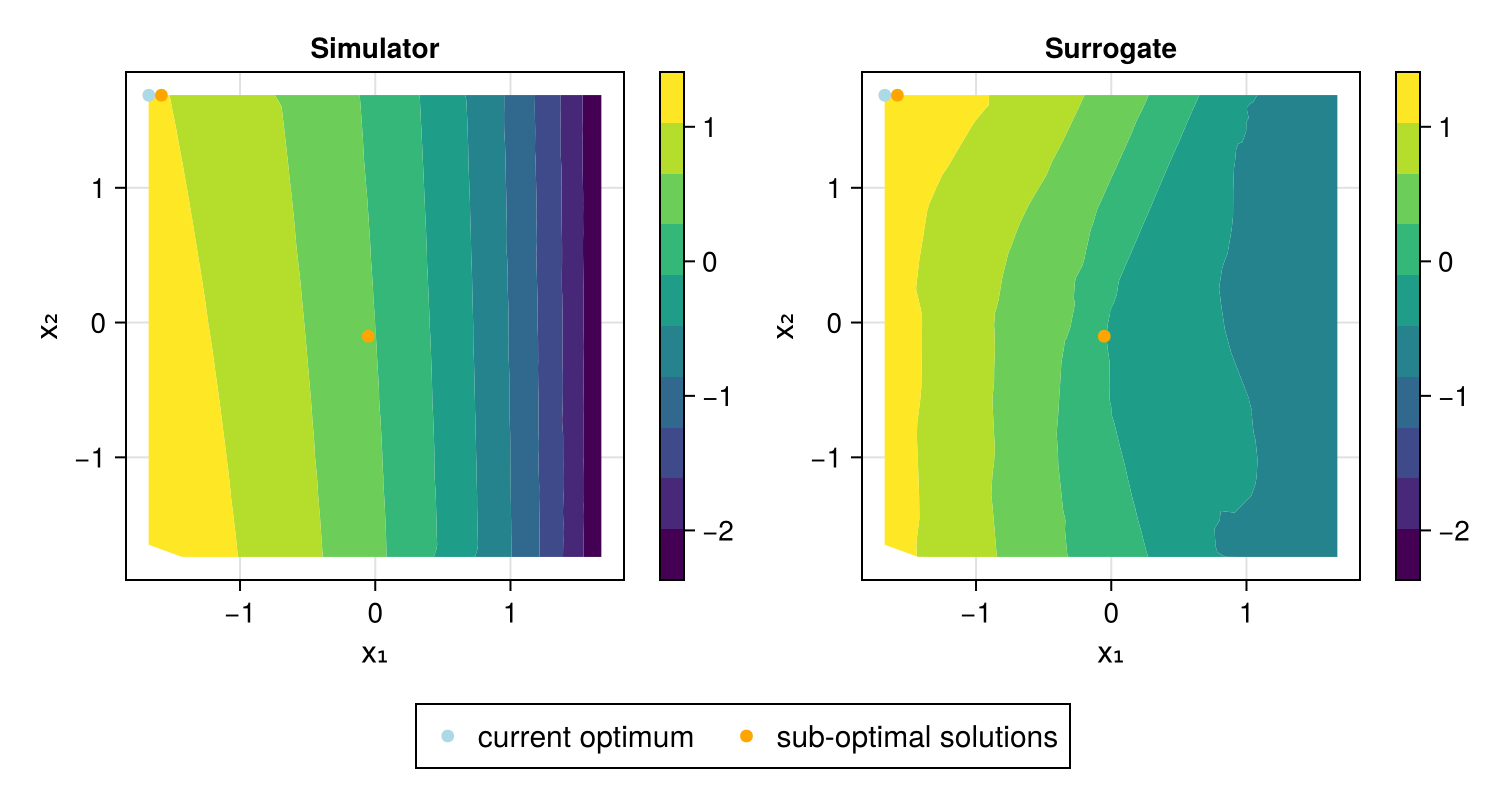

In [17]:
# visualise the surrogate model 
fig = plot_dual_contours(data_reformer_norm, model_init, x_star_init_norm, "sub-optimal solutions", sol_pool_x_init_bt[2:end], [1,2], 10)

# Uncertainty estimate

In [24]:
# apply Monte Carlo Dropout to the surrogate model
config_reformer_dp = NN_Config([2,10,10,10,10,12], [relu, relu, relu, relu, identity], false, 0, 0.2, Adam(0.001, (0.9, 0.999), 1e-07), 1, 800, 100, 0)
train_time = @elapsed result_reformer = NN_train(data_reformer_norm, config_reformer_dp)

# select the top 10 points with the highest uncertainty
pred, pred_dist, means, stds, x_top_std, mc_time_init = predict_dist(data_reformer_norm, result_reformer.model, 100, 10)

Epoch: 100


(Matrix{Float32}[[-0.212286 -0.5232238 … 0.5436049 0.15934956; -0.7031082 -1.2782669 … -0.119418316 -0.100134395; … ; 0.19956455 0.39989996 … 0.10801525 0.05841387; -0.23499411 -0.5416656 … 0.2170966 0.021817647], [-0.36824188 0.10631164 … 0.7108951 -0.1888805; -0.7818594 -0.19439623 … 0.06462371 -0.24583995; … ; 0.27140746 0.021893159 … 0.106041916 0.07981896; -0.39254758 0.022713087 … 0.15245217 -0.13259238], [-0.34980398 -0.4359594 … 0.5436049 -0.1888805; -0.71705824 -0.9975968 … -0.119418316 -0.24583995; … ; 0.26169428 0.28097326 … 0.10801525 0.07981896; -0.3792613 -0.4154174 … 0.2170966 -0.13259238], [-0.34980398 -0.45959935 … 0.6199045 -0.1888805; -0.71705824 -1.2007393 … 0.09688155 -0.24583995; … ; 0.26169428 0.3831306 … 0.13189381 0.07981896; -0.3792613 -0.58371127 … 0.11743808 -0.13259238], [-0.31189507 -0.5232238 … 0.5436049 -0.21752608; -0.6142024 -1.2782669 … -0.119418316 -0.36344206; … ; 0.23109585 0.39989996 … 0.10801525 0.034112208; -0.34826142 -0.5416656 … 0.2170966 -0.

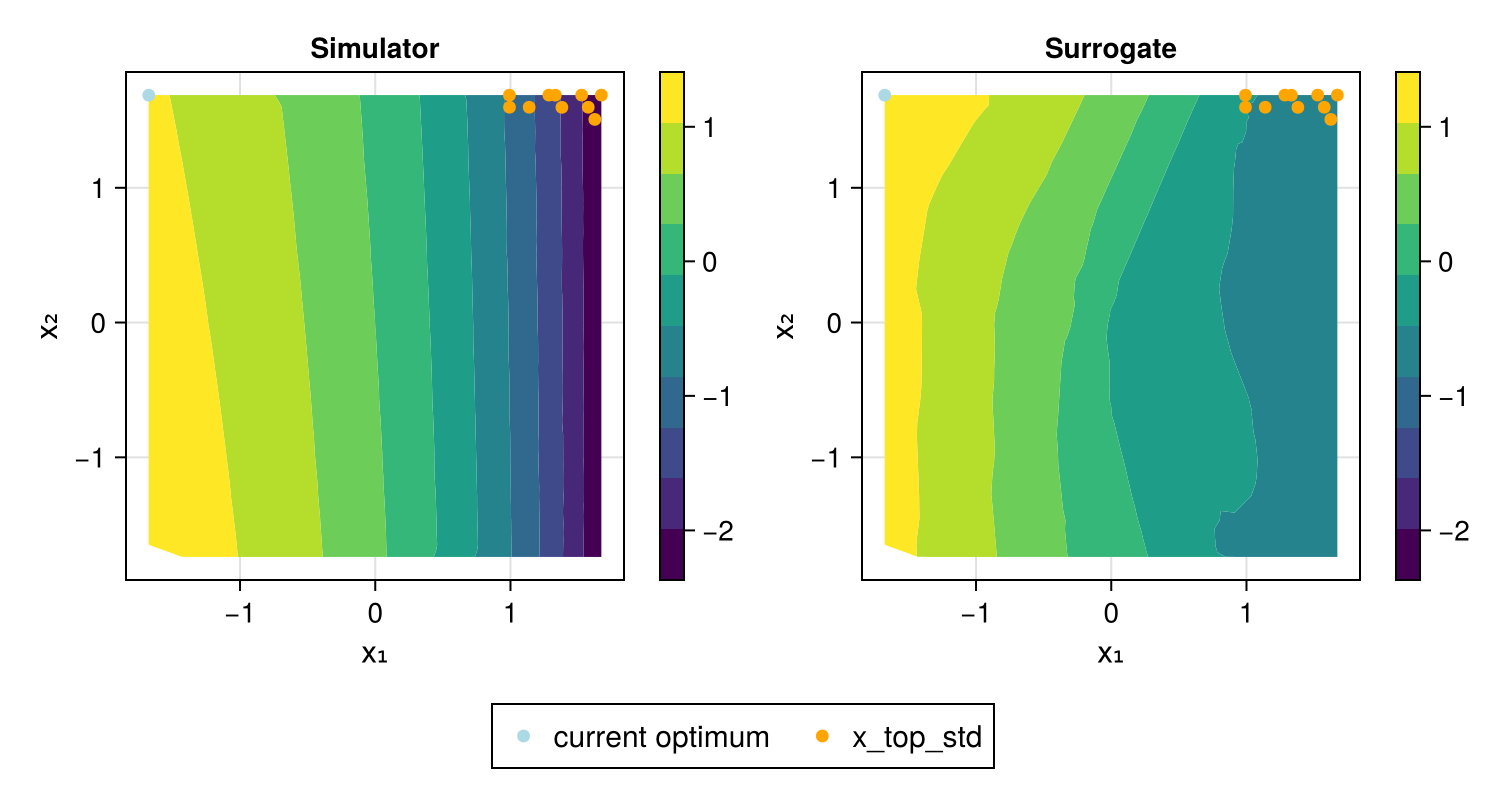

In [25]:
fig = plot_dual_contours(data_reformer_norm, model_init, x_star_init_norm, "x_top_std", [col for col in eachcol(x_top_std)], [1,2], 10)

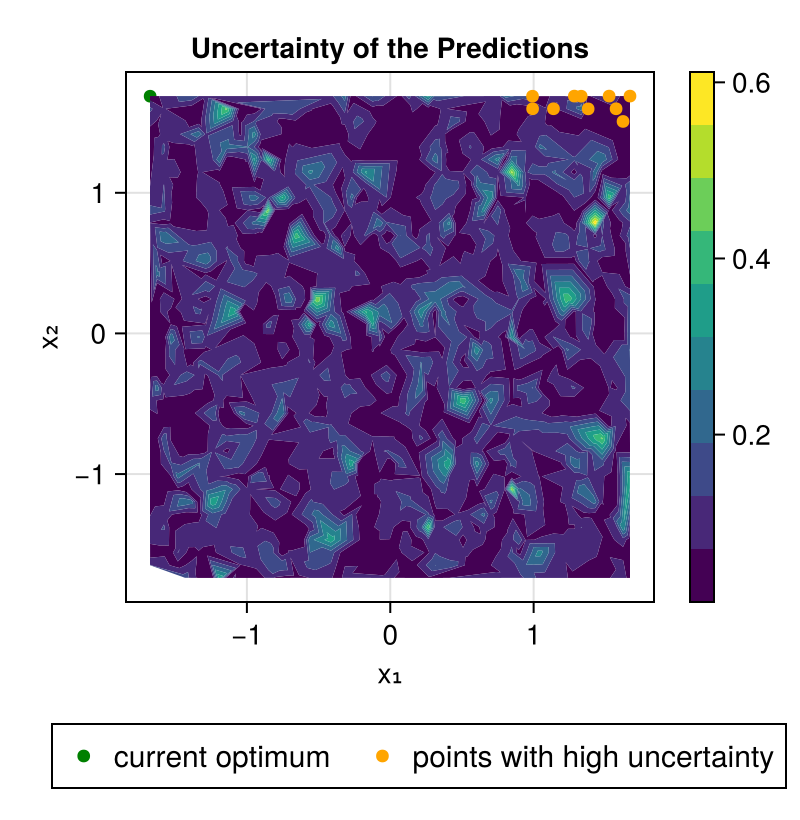

In [26]:
fig = plot_single_contour(data_reformer_norm, result_reformer.model, x_star_init_norm, "Uncertainty of the Predictions", vec(stds),"points with high uncertainty", [col for col in eachcol(x_top_std)], [1,2])

# Iterative refinement

## 1st iteration

Resample

In [27]:
sampling_configs_1st, sampling_config_1st, resample_config_time_1st = generate_resample_configs_mc(sampling_config_init_norm, [x_top_std x_star_init_norm hcat(sol_pool_x_init_bt...)[:, 2:end]], 0.10, 0.3, mean_init, std_init)
x_1st_added, y_1st_added, selected_indices_1st, complement_indices_1st, resample_data_time_1st =  extract_data_from_given_dataset(x[:, complement_indices], y[:, complement_indices], sampling_configs_1st, complement_indices)

Not enough data points meet the criteria for config with bounds [0.6229710236315019, 1.1800000438606753] to [0.692971023631502, 1.2]
Not enough data points meet the criteria for config with bounds [0.7550511620910412, 1.15904234610626] to [0.8, 1.19904234610626]
Not enough data points meet the criteria for config with bounds [0.7652019933301626, 1.1801064250032547] to [0.8, 1.2]
Not enough data points meet the criteria for config with bounds [0.7041304393808956, 1.16947362980244] to [0.7741304393808954, 1.2]
Not enough data points meet the criteria for config with bounds [0.6535433235377931, 1.169574329857824] to [0.723543323537793, 1.2]
Not enough data points meet the criteria for config with bounds [0.7449004306072811, 1.169574329857824] to [0.8, 1.2]
Not enough data points meet the criteria for config with bounds [0.6839956925609557, 1.1801064250032547] to [0.7539956925609557, 1.2]
Not enough data points meet the criteria for config with bounds [0.6230909420452103, 1.169574329857824

([0.6884057971014493 0.6782608695652175 … 0.4449275362318841 0.4246376811594203; 1.2 1.2 … 1.0105263157894737 1.0], [0.4531308965217391 0.4678839954782607 … 0.6797518075606407 0.6972595578260868; 15574.902890764473 15971.561485115444 … 23286.271875290404 23930.499390457535; … ; 0.11900976806556088 0.12040412278015108 … 0.1239187969233184 0.12401317988422009; 0.2590799091046071 0.261935635898362 … 0.3140546300932892 0.31721177803413936], [1640, 1660, 1680, 1719, 1739, 1740, 1760, 1418, 1419, 1437  …  738, 758, 760, 778, 779, 780, 2061, 2081, 2102, 2141], [2, 3, 5, 6, 7, 8, 10, 12, 14, 16  …  2785, 2786, 2787, 2788, 2789, 2793, 2794, 2795, 2796, 2798], 0.5369999408721924)

In [28]:
x_1st = hcat(x_1st_added, x_init)
y_1st = hcat(y_1st_added, y_init)
data_reformer_1st = create_nn_data(x_1st, y_1st)

NN_Data(Float32[0.6884058 0.67826086 … 0.20144928 0.56666666; 1.2 1.2 … 0.9263158 0.9263158], Float32[0.4531309 0.467884 … 0.8964264 0.48644555; 15574.903 15971.562 … 31246.4 17905.77; … ; 0.11900977 0.120404124 … 0.12557076 0.10804288; 0.2590799 0.26193562 … 0.3433728 0.29758418], Float32[0.8 0.5565217 … 0.24202898 0.6173913; 1.0421053 1.1368421 … 1.0631579 0.8947368], Float32[0.25257748 0.61097795 … 0.9765701 0.4148616; 10726.904 20296.828 … 32064.402 15901.807; … ; 0.08778981 0.1279534 … 0.13821818 0.101041354; 0.22095956 0.2913426 … 0.33304155 0.28777304])

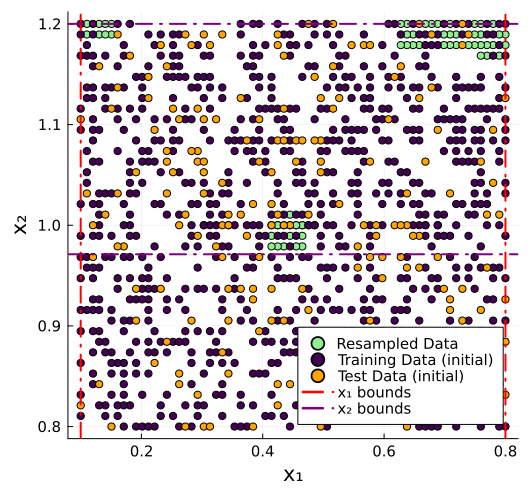

In [30]:
Plots.scatter(x_1st_added[1, :], x_1st_added[2, :], color = :lightgreen, xlabel="x₁", ylabel="x₂", legend=:bottomright, label="Resampled Data", size = (530, 500), legendfontsize = 10, tickfontsize = 10, labelfontsize = 14)
Plots.scatter!(data_reformer.x_train[1, :], data_reformer.x_train[2, :], color = :viridis, xlabel="x₁", ylabel="x₂", legend=:bottomright, label="Training Data (initial) ", legendfontsize = 10, tickfontsize = 10, labelfontsize = 14)
Plots.scatter!(data_reformer.x_test[1, :], data_reformer.x_test[2, :], color = :orange, legend=:bottomright, label="Test Data (initial)", legendfontsize = 10, tickfontsize = 10, labelfontsize = 14)
vline!([sampling_config_1st.lb[1],sampling_config_1st.ub[1]], label="x₁ bounds", linestyle=:dashdot, color=:red, linewidth = 2, legendfontsize = 10, tickfontsize = 10, labelfontsize = 14)
hline!([sampling_config_1st.lb[2],sampling_config_1st.ub[2]], label="x₂ bounds", linestyle=:dashdot, color=:purple, linewidth = 2, legendfontsize = 10, tickfontsize = 10, labelfontsize = 14)

Retrain

In [29]:
# train with the filtered combined data
data_reformer_1st_filtered = filter_data_within_bounds(data_reformer_1st, sampling_config_1st.lb, sampling_config_1st.ub)
data_reformer_1st_filtered_norm, mean_1st_filtered, std_1st_filtered, mean_1st_filtered_y, std_1st_filtered_y = normalise_data(data_reformer_1st_filtered, true)

sampling_config_1st_filtered_norm = Sampling_Config(
    sampling_config_1st.n_samples,
    (sampling_config_1st.lb .- vec(mean_1st_filtered)) ./ vec(std_1st_filtered),
    (sampling_config_1st.ub .- vec(mean_1st_filtered)) ./ vec(std_1st_filtered)
)

Sampling_Config(308, [-1.78625646599661, -1.717031434643365], [1.6451971072072558, 1.7346575515327591])

In [30]:
config_reformer_1st = NN_Config([2,10,10,10,10,12], [relu, relu, relu, relu, identity], false, 0, 0.0, Adam(0.001, (0.9, 0.999), 1e-07), 1, size(data_reformer_1st_filtered_norm.x_train)[2], 100, 1)
train_time_1st = @elapsed result_reformer_1st = NN_train(data_reformer_1st_filtered_norm, config_reformer_1st, trained_model = model_init)
NN_results(config_reformer_1st, result_reformer_1st)

model_1st = result_reformer_1st.model

Epoch: 100
Layers: [2, 10, 10, 10, 10, 12], Epochs: 100, Lambda: 0.0, Dropout rate: 0.0
    Train Error[MSE, RRMSE, MAPE]: Float32[0.15085164, 0.0059184283, 1.9397095]
    Test Error [MSE, RRMSE, MAPE]: Float32[0.10104485, 0.010645255, 14.616988]


Chain(
  Dense(2 => 10),                       # 30 parameters
  NNlib.relu,
  Dropout(0.0, active=false),
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 12),                      # 132 parameters
  identity,
)                   # Total: 10 arrays, 492 parameters, 2.579 KiB.

In [31]:
BSON.@save joinpath(@__DIR__, "models/surrogate_1st.bson") model_1st
# BSON.@load joinpath(@__DIR__, "models/surrogate_1st.bson") model_1st

Rebuild and resolve

In [32]:
# convert the surrogate model to a MILP model
MILP_bt_1st = Model()
set_optimizer(MILP_bt_1st, Gurobi.Optimizer)
set_silent(MILP_bt_1st)
set_attribute(MILP_bt_1st, "TimeLimit", 10)

build_time = @elapsed compressed_model_1st, removed_neurons_1st, bounds_U_1st, bounds_L_1st = NN_formulate!(MILP_bt_1st, model_1st, sampling_config_1st_filtered_norm.ub, sampling_config_1st_filtered_norm.lb; bound_tightening="fast", compress=true, silent=false)


Set parameter Username
Set parameter LicenseID to value 2603857
Academic license - for non-commercial use only - expires 2025-12-27
Starting compression...

LAYER 1
Removed 0/10 neurons

LAYER 2
Removed 0/10 neurons

LAYER 3
Removed 0/10 neurons

LAYER 4
Removed 0/10 neurons

LAYER 5
Creating JuMP model...

LAYER 1

LAYER 2

LAYER 3

LAYER 4

LAYER 5


0.0223349

In [35]:
@objective(MILP_bt_1st, Max, MILP_bt_1st[:x][5,10])
@constraint(MILP_bt_1st, MILP_bt_1st[:x][5,12] <= (0.34 - mean_1st_filtered_y[12])/std_1st_filtered_y[12])

set_attribute(MILP_bt_1st, "TimeLimit", 1800)
solving_time = @elapsed optimize!(MILP_bt_1st)

0.2119622

In [34]:
x_star_1st_norm = [value.(MILP_bt_1st[:x][0,i]) for i in 1:length(MILP_bt_1st[:x][0,:])]
x_star_1st = [value.(MILP_bt_1st[:x][0,i]) for i in 1:length(MILP_bt_1st[:x][0,:])] .* std_1st_filtered .+ mean_1st_filtered

println("Bypass Fraction:", x_star_1st[1])
println("NG Steam Ratio:", x_star_1st[2])
println("H2 Concentration:", (h2_1st = objective_value(MILP_bt_1st) * std_1st_filtered_y[10] + mean_1st_filtered_y[10]; h2_1st))
println("N2 Concentration:", value.(MILP_bt_1st[:x][5,12]) * std_1st_filtered_y[12] + mean_1st_filtered_y[12])
solution_evaluate_pre(h2_1st, h2_init, 0.001)

Bypass Fraction:0.14641673813807904
NG Steam Ratio:1.0817352817682755
H2 Concentration:0.33618095002211035
N2 Concentration:0.34


In [36]:
# store multiple solutions in the solution pool
num_solutions_1st_filtered = MOI.get(MILP_bt_1st, MOI.ResultCount())
sol_pool_x_1st_filtered, _ = sol_pool(MILP_bt_1st, num_solutions_1st_filtered, mean = mean_1st_filtered, std = std_1st_filtered)

Solution 1:
   x = [0.1464167381380792; 1.0817352817682755;;]
 obj = 1.3928087479062703


(Any[[-1.5587180632246385, -0.0489829844241517]], Any[1.3928087479062703])

In [37]:
# apply Monte Carlo Dropout to the surrogate model
config_reformer_dp = NN_Config([2,10,10,10,10,12], [relu, relu, relu, relu, identity], false, 0, 0.2, Adam(0.001, (0.9, 0.999), 1e-07), 1, size(data_reformer_1st_filtered_norm.x_train)[2], 100, 0)
train_time = @elapsed result_reformer = NN_train(data_reformer_1st_filtered_norm, config_reformer_dp)

pred_1st, pred_dist_1st, means_1st, stds_1st, x_top_std_1st, mc_time_1st = predict_dist(data_reformer_1st_filtered_norm, result_reformer.model, 100, 10)


Epoch: 100


(Matrix{Float32}[[0.16039808 0.14848849 … 0.07897856 0.07665446; -0.37953454 -0.17632315 … 0.19816045 0.18176882; … ; -0.09161867 0.10879547 … 0.12630062 0.09533031; -0.61838186 -0.019805267 … 0.29752618 0.22385451], [0.09629595 0.029961497 … 0.042768423 0.106352486; -0.13931799 -0.65191525 … 0.27138224 0.25020242; … ; 0.013581935 -0.22740248 … 0.13983324 0.17555194; -0.12769105 -0.818587 … 0.37436968 0.41064292], [0.14311019 0.04855115 … 0.07290943 -0.05508039; -0.11553403 -0.5542913 … 0.2482844 0.3871829; … ; 0.06446685 -0.15583943 … 0.14733717 0.14217994; -0.107560635 -0.6892239 … 0.36779648 0.4653616], [0.09787458 -0.032710075 … 0.1226843 -0.05508039; -0.50473356 -0.36264348 … 0.25645313 0.3871829; … ; -0.15203172 -0.10963912 … 0.19488697 0.14217994; -0.7569076 -0.49447155 … 0.44412857 0.4653616], [-0.0023336373 0.04855115 … 0.06261238 -0.0066410247; -0.8187282 -0.5542913 … 0.3075975 0.28579268; … ; -0.33823574 -0.15583943 … 0.17503265 0.107013725; -1.289427 -0.6892239 … 0.45210165

## 2nd iteration

In [38]:
# Resample densely around the points with the highest uncertainty
sampling_configs_2nd, sampling_config_2nd, resample_config_time_2nd = generate_resample_configs_mc(sampling_config_1st_filtered_norm, [x_top_std_1st x_star_1st_norm hcat(sol_pool_x_1st_filtered...)[:, 2:end]], 0.10, 0.3, mean_1st_filtered, std_1st_filtered)
x_2nd_added, y_2nd_added, selected_indices_2nd, complement_indices_2nd, resample_data_time_2nd =  extract_data_from_given_dataset(x[:, complement_indices_1st], y[:, complement_indices_1st], sampling_configs_2nd, complement_indices_1st)

Number of data points added: 61


([0.7289855072463769 0.7289855072463769 … 0.1202898550724637 0.13043478260869568; 1.0105263157894737 1.0 … 1.0736842105263158 1.0842105263157895], [0.3318892637437069 0.3284320839130433 … 1.1446408130251717 1.1425332274599542; 12968.98597758025 12911.792559540241 … 37209.22595573221 37002.92114448866; … ; 0.09800064734820108 0.0971710807214886 … 0.1431665862492637 0.1439559890596421; 0.2515772560999776 0.2518730581196857 … 0.3413728712124891 0.34016293088715055], [1542, 1541, 1501, 159, 1601, 179, 1562, 160, 140, 1481  …  1623, 2728, 2688, 2628, 2648, 2669, 2649, 2709, 2748, 2729], [2, 3, 5, 6, 7, 8, 10, 12, 14, 16  …  2785, 2786, 2787, 2788, 2789, 2793, 2794, 2795, 2796, 2798], 0.37400007247924805)

In [39]:
x_2nd = hcat(x_2nd_added, x_1st)
y_2nd = hcat(y_2nd_added, y_1st)
data_reformer_2nd = create_nn_data(x_2nd, y_2nd)

NN_Data(Float32[0.7289855 0.7289855 … 0.7188406 0.2826087; 1.0105263 1.0 … 1.2 0.9894737], Float32[0.33188927 0.32843208 … 0.4088716 0.8602277; 12968.986 12911.793 … 14402.057 29237.092; … ; 0.098000646 0.09717108 … 0.114459306 0.12929985; 0.25157726 0.25187305 … 0.24976027 0.33319092], Float32[0.6985507 0.41449276 … 0.24202898 0.6173913; 0.9894737 0.86315787 … 1.0631579 0.8947368], Float32[0.36146942 0.612457 … 0.9765701 0.4148616; 13863.084 22551.568 … 32064.402 15901.807; … ; 0.10049746 0.11113185 … 0.13821818 0.101041354; 0.26238763 0.32487527 … 0.33304155 0.28777304])

In [40]:
data_reformer_2nd_filtered = filter_data_within_bounds(data_reformer_2nd, sampling_config_2nd.lb, sampling_config_2nd.ub)
data_reformer_2nd_filtered_norm, mean_2nd_filtered, std_2nd_filtered, mean_2nd_filtered_y, std_2nd_filtered_y = normalise_data(data_reformer_2nd_filtered, true)

sampling_config_2nd_filtered_norm = Sampling_Config(
    sampling_config_2nd.n_samples,
    (sampling_config_2nd.lb .- vec(mean_2nd_filtered)) ./ vec(std_2nd_filtered),
    (sampling_config_2nd.ub .- vec(mean_2nd_filtered)) ./ vec(std_2nd_filtered)
)

Sampling_Config(99, [-1.894285028245876, -1.467009318845797], [1.4880671510138046, 1.964755911181147])

In [42]:
# train with the filtered combined data
config_reformer_2nd = NN_Config([2,10,10,10,10,12], [relu, relu, relu, relu, identity], false, 0, 0.0, Adam(0.001, (0.9, 0.999), 1e-07), 1, size(data_reformer_2nd_filtered_norm.x_train)[2], 100, 1)
train_time_2nd = @elapsed result_reformer_2nd = NN_train(data_reformer_2nd_filtered_norm, config_reformer_2nd, trained_model = model_1st)
NN_results(config_reformer_2nd, result_reformer_2nd)

model_2nd = result_reformer_2nd.model

Epoch: 100
Layers: [2, 10, 10, 10, 10, 12], Epochs: 100, Lambda: 0.0, Dropout rate: 0.0
    Train Error[MSE, RRMSE, MAPE]: Float32[0.0052103642, 0.0012226012, 0.39001092]
    Test Error [MSE, RRMSE, MAPE]: Float32[0.004728177, 0.0027164586, 0.14397843]


Chain(
  Dense(2 => 10),                       # 30 parameters
  NNlib.relu,
  Dropout(0.0, active=false),
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 12),                      # 132 parameters
  identity,
)                   # Total: 10 arrays, 492 parameters, 2.579 KiB.

In [43]:
BSON.@save joinpath(@__DIR__, "models/surrogate_2nd.bson") model_2nd
# BSON.@load joinpath(@__DIR__, "models/surrogate_2nd.bson") model_2nd

In [44]:
# convert the surrogate model to a MILP model
MILP_bt_2nd = Model()
set_optimizer(MILP_bt_2nd, Gurobi.Optimizer)
set_silent(MILP_bt_2nd)
set_attribute(MILP_bt_2nd, "TimeLimit", 10)

build_time = @elapsed compressed_model_2nd, removed_neurons_2nd, bounds_U_2nd, bounds_L_2nd = NN_formulate!(MILP_bt_2nd, model_2nd, sampling_config_2nd_filtered_norm.ub, sampling_config_2nd_filtered_norm.lb; bound_tightening="fast", compress=true, silent=false)

Set parameter Username
Set parameter LicenseID to value 2603857
Academic license - for non-commercial use only - expires 2025-12-27
Starting compression...

LAYER 1
Removed 0/10 neurons

LAYER 2
Removed 0/10 neurons

LAYER 3
Removed 0/10 neurons

LAYER 4
Removed 0/10 neurons

LAYER 5
Creating JuMP model...

LAYER 1

LAYER 2

LAYER 3

LAYER 4

LAYER 5


0.0050989

In [45]:
@objective(MILP_bt_2nd, Max, MILP_bt_2nd[:x][5,10])
@constraint(MILP_bt_2nd, MILP_bt_2nd[:x][5,12] <= (0.34 - mean_2nd_filtered_y[12])/std_2nd_filtered_y[12])

set_attribute(MILP_bt_2nd, "TimeLimit", 1800)
unset_silent(MILP_bt_2nd)
solving_time = @elapsed optimize!(MILP_bt_2nd)

Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 1800
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  1800

Optimize a model with 217 rows, 134 columns and 777 nonzeros
Model fingerprint: 0xe068c399
Variable types: 94 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [4e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-04, 1e+01]
Presolve removed 96 rows and 12 columns
Presolve time: 0.00s
Presolved: 121 rows, 122 columns, 570 nonzeros
Variable types: 82 continuous, 40 integer (40 binary)

Root relaxation: objective 4.378325e+00, 164 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    

0.1105105

In [46]:
x_star_2nd_norm = [value.(MILP_bt_2nd[:x][0,i]) for i in 1:length(MILP_bt_2nd[:x][0,:])]
x_star_2nd = [value.(MILP_bt_2nd[:x][0,i]) for i in 1:length(MILP_bt_2nd[:x][0,:])] .* std_2nd_filtered .+ mean_2nd_filtered

println("Bypass Fraction:", x_star_2nd[1])
println("NG Steam Ratio:", x_star_2nd[2])
println("H2 Concentration:", (h2_2nd = objective_value(MILP_bt_2nd) * std_2nd_filtered_y[10] + mean_2nd_filtered_y[10]; h2_2nd))
println("N2 Concentration:", value.(MILP_bt_2nd[:x][5,12]) * std_2nd_filtered_y[12] + mean_2nd_filtered_y[12])
solution_evaluate_pre(h2_2nd, h2_1st, 0.001)

Bypass Fraction:0.14788468937027383
NG Steam Ratio:1.07543037503166
H2 Concentration:0.3308505750328336
N2 Concentration:0.34


In [47]:
# store multiple solutions in the solution pool
num_solutions_2nd_filtered = MOI.get(MILP_bt_2nd, MOI.ResultCount())
sol_pool_x_2nd_filtered, _ = sol_pool(MILP_bt_2nd, num_solutions_2nd_filtered, mean = mean_2nd_filtered, std = std_2nd_filtered)

Solution 1:
   x = [0.14788468937027383; 1.07543037503166;;]
 obj = 1.3149308622305607
Solution 2:
   x = [0.15564017941781988; 1.052299319883526;;]
 obj = 1.3033175517260993
Solution 3:
   x = [0.17251662749430025; 1.0178642362675008;;]
 obj = 1.2924783162782307
Solution 4:
   x = [0.20621200340016993; 1.0269910606627024;;]
 obj = 1.1883636409204161
Solution 5:
   x = [0.37213778598722597; 1.0500443156430685;;]
 obj = 0.7247268986867064
Solution 6:
   x = [0.4269192601861253; 1.0266160170986525;;]
 obj = 0.5878861023617938


(Any[[-1.7151527995741833, 1.4362004552712855], [-1.677057481089947, 0.7473377755487948], [-1.5941596035329222, -0.2781685761628247], [-1.4286463904785998, -0.006363910531636116], [-0.6136114289676762, 0.6801818134052989], [-0.3445223457699776, -0.017533029834220573]], Any[1.3149308622305607, 1.3033175517260993, 1.2924783162782307, 1.1883636409204161, 0.7247268986867064, 0.5878861023617938])

In [48]:
# apply Monte Carlo Dropout to the surrogate model
config_reformer_dp = NN_Config([2,10,10,10,10,12], [relu, relu, relu, relu, identity], false, 0, 0.2, Adam(0.001, (0.9, 0.999), 1e-07), 1, size(data_reformer_2nd_filtered_norm.x_train)[2], 100, 0)
train_time = @elapsed result_reformer = NN_train(data_reformer_2nd_filtered_norm, config_reformer_dp)
NN_results(config_reformer_dp, result_reformer)

pred_2nd, pred_dist_2nd, means_2nd, stds_2nd, x_top_std_2nd, mc_time_2nd = predict_dist(data_reformer_2nd_filtered_norm, result_reformer.model, 100, 50)


Epoch: 100
Layers: [2, 10, 10, 10, 10, 12], Epochs: 100, Lambda: 0.0, Dropout rate: 0.2
    Train Error[MSE, RRMSE, MAPE]: Float32[0.65659654, 0.033505302, 1.363591]
    Test Error [MSE, RRMSE, MAPE]: Float32[0.43949327, 0.052226666, 0.82596874]


(Matrix{Float32}[[-0.1984658 -0.20295629 … 0.2223739 0.8385181; -0.098606594 -0.100130446 … 0.44801506 1.0256724; … ; -0.11751553 -0.11707265 … 0.28067937 0.7460978; -0.13347334 -0.13516001 … 0.21144754 0.48991993], [-0.21481818 -0.20203581 … 0.25613564 0.50159866; -0.10242815 -0.1001416 … 0.68786484 0.7979093; … ; -0.11519527 -0.1166254 … 0.16698825 0.271797; -0.1398236 -0.13417749 … 0.28831872 0.5287793], [-0.21386078 -0.20295629 … 0.5751362 0.8312326; -0.098080665 -0.100130446 … 0.8068473 1.0244226; … ; -0.11559321 -0.11707265 … 0.5235472 0.7410712; -0.14168799 -0.13516001 … 0.32189912 0.48758623], [-0.1867139 -0.13654652 … 0.2223739 0.29863235; -0.09794151 -0.09126438 … 0.44801506 0.5850216; … ; -0.11359694 -0.105352744 … 0.28067937 0.35521314; -0.12291889 -0.085442096 … 0.21144754 0.2577476], [-0.13586535 -0.14076787 … 0.117707886 0.8385181; -0.08914539 -0.11186264 … 0.33414 1.0256724; … ; -0.09850725 -0.08632714 … 0.2292445 0.7460978; -0.086656354 -0.08461492 … 0.17121159 0.48991

## 3rd iteration

In [49]:
# Resample densely around the points with the highest uncertainty
sampling_configs_3rd, sampling_config_3rd, resample_config_time_3rd = generate_resample_configs_mc(sampling_config_2nd_filtered_norm, [x_top_std_2nd x_star_2nd_norm hcat(sol_pool_x_2nd_filtered...)[:, 2:end]], 0.10, 0.3, mean_2nd_filtered, std_2nd_filtered)
x_3rd_added, y_3rd_added, selected_indices_3rd, complement_indices_3rd, resample_data_time_3rd =  extract_data_from_given_dataset(x[:, complement_indices_2nd], y[:, complement_indices_2nd], sampling_configs_3rd, complement_indices_2nd)

Number of data points added: 34


([0.1507246376811594 0.14057971014492754 … 0.39420289855072466 0.41449275362318844; 1.0842105263157895 1.0736842105263158 … 1.0526315789473684 1.0315789473684212], [1.115874118819222 1.1182405306819223 … 0.7727813739130435 0.7319607692814646; 36169.14264838765 36380.11750838853 … 25807.981950290265 24729.985963717267; … ; 0.14335581687817758 0.14258137800850726 … 0.1306924804266297 0.12760472677256363; 0.33880870123938955 0.3400401795923387 … 0.31856946572314454 0.31707057957570994], [2689, 2708, 2629, 2569, 2608, 2429, 2687, 2509, 2528, 2667  …  2527, 1280, 2682, 2189, 2647, 2706, 2663, 2544, 2206, 2164], [2, 3, 5, 6, 7, 8, 10, 12, 14, 16  …  2785, 2786, 2787, 2788, 2789, 2793, 2794, 2795, 2796, 2798], 0.14600014686584473)

In [50]:
x_3rd = hcat(x_3rd_added, x_2nd)
y_3rd = hcat(y_3rd_added, y_2nd)
data_reformer_3rd = create_nn_data(x_3rd, y_3rd)

NN_Data(Float32[0.15072463 0.14057972 … 0.6478261 0.2521739; 1.0842105 1.0736842 … 1.0 1.1789473], Float32[1.1158742 1.1182405 … 0.42678607 1.068435; 36169.145 36380.117 … 15674.264 33626.227; … ; 0.14335582 0.14258137 … 0.107288115 0.14938425; 0.33880872 0.34004018 … 0.2764998 0.32654345], Float32[0.34347826 0.67826086 … 0.24202898 0.6173913; 1.0421053 0.94736844 … 1.0631579 0.8947368], Float32[0.82911307 0.3693821 … 0.9765701 0.4148616; 27668.484 14269.355 … 32064.402 15901.807; … ; 0.13206914 0.09946782 … 0.13821818 0.101041354; 0.32466954 0.26988107 … 0.33304155 0.28777304])

In [51]:
data_reformer_3rd_filtered = filter_data_within_bounds(data_reformer_3rd, sampling_config_3rd.lb, sampling_config_3rd.ub)
data_reformer_3rd_filtered_norm, mean_3rd_filtered, std_3rd_filtered, mean_3rd_filtered_y, std_3rd_filtered_y = normalise_data(data_reformer_3rd_filtered, true)

sampling_config_3rd_filtered_norm = Sampling_Config(
    sampling_config_3rd.n_samples,
    (sampling_config_3rd.lb .- vec(mean_3rd_filtered)) ./ vec(std_3rd_filtered),
    (sampling_config_3rd.ub .- vec(mean_3rd_filtered)) ./ vec(std_3rd_filtered)
)

Sampling_Config(56, [-1.5141362545820596, -1.564452064632114], [1.6297990504889777, 1.5489931554745928])

In [52]:
# train with the filtered combined data
config_reformer_3rd = NN_Config([2,10,10,10,10,12], [relu, relu, relu, relu, identity], false, 0, 0.0, Adam(0.001, (0.9, 0.999), 1e-07), 1, size(data_reformer_3rd_filtered_norm.x_train)[2], 100, 1)
train_time_3rd = @elapsed result_reformer_3rd = NN_train(data_reformer_3rd_filtered_norm, config_reformer_3rd, trained_model = model_2nd)
NN_results(config_reformer_3rd, result_reformer_3rd)

model_3rd = result_reformer_3rd.model

Epoch: 100
Layers: [2, 10, 10, 10, 10, 12], Epochs: 100, Lambda: 0.0, Dropout rate: 0.0
    Train Error[MSE, RRMSE, MAPE]: Float32[0.002779855, 0.0012295691, 0.19166113]
    Test Error [MSE, RRMSE, MAPE]: Float32[0.0052797496, 0.003591546, 0.30332544]


Chain(
  Dense(2 => 10),                       # 30 parameters
  NNlib.relu,
  Dropout(0.0, active=false),
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 12),                      # 132 parameters
  identity,
)                   # Total: 10 arrays, 492 parameters, 2.579 KiB.

In [53]:
BSON.@save joinpath(@__DIR__, "models/surrogate_3rd.bson") model_3rd
# BSON.@load joinpath(@__DIR__, "models/surrogate_3rd.bson") model_3rd

In [54]:
# convert the surrogate model to a MILP model
MILP_bt_3rd = Model()
set_optimizer(MILP_bt_3rd, Gurobi.Optimizer)
set_silent(MILP_bt_3rd)
set_attribute(MILP_bt_3rd, "TimeLimit", 10)

build_time = @elapsed compressed_model_3rd, removed_neurons_3rd, bounds_U_3rd, bounds_L_3rd = NN_formulate!(MILP_bt_3rd, model_3rd, sampling_config_3rd_filtered_norm.ub, sampling_config_3rd_filtered_norm.lb; bound_tightening="fast", compress=true, silent=false)

Set parameter Username
Set parameter LicenseID to value 2603857
Academic license - for non-commercial use only - expires 2025-12-27
Starting compression...

LAYER 1
Removed 0/10 neurons

LAYER 2
Removed 0/10 neurons

LAYER 3
Removed 0/10 neurons

LAYER 4
Removed 0/10 neurons

LAYER 5
Creating JuMP model...

LAYER 1

LAYER 2

LAYER 3

LAYER 4

LAYER 5


0.0396622

In [55]:
@objective(MILP_bt_3rd, Max, MILP_bt_3rd[:x][5,10])
@constraint(MILP_bt_3rd, MILP_bt_3rd[:x][5,12] <= (0.34 - mean_3rd_filtered_y[12])/std_3rd_filtered_y[12])

set_attribute(MILP_bt_3rd, "TimeLimit", 1800)
solving_time = @elapsed optimize!(MILP_bt_3rd)

0.1524948

In [56]:
x_star_3rd_norm = [value.(MILP_bt_3rd[:x][0,i]) for i in 1:length(MILP_bt_3rd[:x][0,:])]
x_star_3rd = [value.(MILP_bt_3rd[:x][0,i]) for i in 1:length(MILP_bt_3rd[:x][0,:])] .* std_3rd_filtered .+ mean_3rd_filtered

println("Bypass Fraction:", x_star_3rd[1])
println("NG Steam Ratio:", x_star_3rd[2])
println("H2 Concentration:", (h2_3rd = objective_value(MILP_bt_3rd) * std_3rd_filtered_y[10] + mean_3rd_filtered_y[10]; h2_3rd))
println("N2 Concentration:", value.(MILP_bt_3rd[:x][5,12]) * std_3rd_filtered_y[12] + mean_3rd_filtered_y[12])
solution_evaluate_pre(h2_3rd, h2_2nd, 0.001)

Bypass Fraction:0.14396063764541264
NG Steam Ratio:1.0674869129715276
H2 Concentration:0.33040598511719793
N2 Concentration:0.34


In [57]:
# store multiple solutions in the solution pool
num_solutions_3rd_filtered = MOI.get(MILP_bt_3rd, MOI.ResultCount())
sol_pool_x_3rd_filtered, _ = sol_pool(MILP_bt_3rd, num_solutions_3rd_filtered, mean = mean_3rd_filtered, std = std_3rd_filtered)

Solution 1:
   x = [0.14396063764541264; 1.0674869129715276;;]
 obj = 1.1192812117471511
Solution 2:
   x = [0.13185525128939826; 1.0866908544469462;;]
 obj = 1.0825497328455402
Solution 3:
   x = [0.2615212869640874; 1.0430417048196117;;]
 obj = 0.3103824367951929


(Any[[-1.2217480000445444, 0.9223218902062648], [-1.3305079470920609, 1.455654849737283], [-0.1655330541730945, 0.24342817316899557]], Any[1.1192812117471511, 1.0825497328455402, 0.3103824367951929])

In [60]:
# apply Monte Carlo Dropout to the surrogate model
config_reformer_dp = NN_Config([2,10,10,10,10,12], [relu, relu, relu, relu, identity], false, 0, 0.2, Adam(0.001, (0.9, 0.999), 1e-07), 1, size(data_reformer_3rd_filtered_norm.x_train)[2], 100, 0)
train_time = @elapsed result_reformer = NN_train(data_reformer_3rd_filtered_norm, config_reformer_dp)

pred_3rd, pred_dist_3rd, means_3rd, stds_3rd, x_top_std_3rd, mc_time_3rd = predict_dist(data_reformer_3rd_filtered_norm, result_reformer.model, 100, 50)

Epoch: 100


(Matrix{Float32}[[-0.121308826 -0.113932654 … -0.30734503 -0.06468028; -0.022694811 -0.0009082407 … -0.72641885 0.06028262; … ; 0.43159962 0.37965685 … -0.28363228 0.21246642; 0.036755778 0.017009601 … 0.111254975 -0.031735018], [-0.11003259 -0.082963735 … -0.27162838 -0.05270349; 0.005210981 0.0060074106 … -0.74357307 0.07483436; … ; 0.35819662 0.31462687 … -0.30956632 0.17267172; 0.011523716 0.01565282 … 0.12993215 -0.04325389], [-0.102038845 -0.11757247 … -0.35469556 -0.073185384; 0.01365567 -0.004590392 … -1.0083033 0.049948968; … ; 0.33984125 0.38980788 … -0.5309817 0.2407259; 0.0054553747 0.019755863 … 0.1163072 -0.0235551], [-0.06913284 -0.11757247 … -0.66698474 -0.05270349; 0.009397715 -0.004590392 … -1.624099 0.07483436; … ; 0.06453474 0.38980788 … -0.56356555 0.17267172; -0.04455796 0.019755863 … 0.3236887 -0.04325389], [-0.05512844 -0.09725309 … -0.6890048 -0.06468028; -0.017055333 0.020706825 … -1.6550772 0.06028262; … ; 0.31957287 0.3206945 … -0.6072138 0.21246642; 0.04873

## 4th iteration

In [61]:
# Resample densely around the points with the highest uncertainty
sampling_configs_4th, sampling_config_4th = generate_resample_configs_mc(sampling_config_3rd_filtered_norm, [x_top_std_3rd x_star_3rd_norm hcat(sol_pool_x_3rd_filtered...)[:, 2:end]], 0.10, 0.3, mean_3rd_filtered, std_3rd_filtered)
x_4th_added, y_4th_added, selected_indices_4th, complement_indices_4th, resample_data_time_4th =  extract_data_from_given_dataset(x[:, complement_indices_3rd], y[:, complement_indices_3rd], sampling_configs_4th, complement_indices_3rd)

Not enough data points meet the criteria for config with bounds [0.4375758768940827, 1.0786051593706112] to [0.4613484232792214, 1.0898158709393144]
Not enough data points meet the criteria for config with bounds [0.41728600857300013, 1.0786051593706112] to [0.4522791770871144, 1.0898158709393144]
Not enough data points meet the criteria for config with bounds [0.39740645339819314, 1.0787479853011417] to [0.4323996219123074, 1.089958696869845]
Not enough data points meet the criteria for config with bounds [0.40714109431511436, 1.0786051593706112] to [0.44213426282922863, 1.0898158709393144]
Not enough data points meet the criteria for config with bounds [0.4279340354256498, 1.0787479853011417] to [0.4613484232792214, 1.089958696869845]
Not enough data points meet the criteria for config with bounds [0.3668788581022995, 1.0787479853011417] to [0.40187202661641375, 1.089958696869845]
Not enough data points meet the criteria for config with bounds [0.376706298467709, 1.0786051593706112] 

([0.45507246376811594 0.4449275362318841 … 0.14057971014492754 0.2623188405797101; 1.0736842105263158 1.0526315789473684 … 1.063157894736842 1.0421052631578946], [0.709036154361556 0.708074799542334 … 1.1072773882242561 0.9316082826041189; 23663.038192700536 23805.791429222216 … 36174.50974816904 30894.157687595784; … ; 0.12935103189918612 0.12794754782622453 … 0.14150209643004633 0.1353598118318638; 0.3099107826296541 0.3122007485400404 … 0.3405897976552592 0.33237689044798785], [2088, 2106, 2107, 2148, 2105, 2125, 2208, 2268, 2124, 2181, 2146, 2247, 2226, 2167, 2707, 2465], [2, 3, 5, 6, 7, 8, 10, 12, 14, 16  …  2785, 2786, 2787, 2788, 2789, 2793, 2794, 2795, 2796, 2798], 0.20000004768371582)

In [62]:
x_4th = hcat(x_4th_added, x_3rd)
y_4th = hcat(y_4th_added, y_3rd)
data_reformer_4th = create_nn_data(x_4th, y_4th)

NN_Data(Float32[0.45507246 0.44492754 … 0.6478261 0.5768116; 1.0736842 1.0526316 … 0.8842105 0.9157895], Float32[0.7090362 0.7080748 … 0.37736875 0.4696588; 23663.04 23805.791 … 14824.5 17456.857; … ; 0.12935103 0.12794755 … 0.09729753 0.106299855; 0.30991077 0.31220075 … 0.28050914 0.2959466], Float32[0.20144928 0.6478261 … 0.24202898 0.6173913; 1.1263158 1.0 … 1.0631579 0.8947368], Float32[1.089973 0.42678607 … 0.9765701 0.4148616; 34853.406 15674.264 … 32064.402 15901.807; … ; 0.14599362 0.107288115 … 0.13821818 0.101041354; 0.33306158 0.2764998 … 0.33304155 0.28777304])

In [63]:
data_reformer_4th_filtered = filter_data_within_bounds(data_reformer_4th, sampling_config_4th.lb, sampling_config_4th.ub)
data_reformer_4th_filtered_norm, mean_4th_filtered, std_4th_filtered, mean_4th_filtered_y, std_4th_filtered_y = normalise_data(data_reformer_4th_filtered, true)

sampling_config_4th_filtered_norm = Sampling_Config(
    sampling_config_4th.n_samples,
    (sampling_config_4th.lb .- vec(mean_4th_filtered)) ./ vec(std_4th_filtered),
    (sampling_config_4th.ub .- vec(mean_4th_filtered)) ./ vec(std_4th_filtered)
)

Sampling_Config(53, [-1.5498466443260976, -1.6485597620508654], [1.5121945458449315, 1.5313241609795054])

In [ ]:
# train with the filtered combined data
config_reformer_4th = NN_Config([2,10,10,10,10,12], [relu, relu, relu, relu, identity], false, 0, 0.0, Adam(0.001, (0.9, 0.999), 1e-07), 1, size(data_reformer_4th_filtered_norm.x_train)[2], 100, 1)
train_time_4th = @elapsed result_reformer_4th = NN_train(data_reformer_4th_filtered_norm, config_reformer_4th, trained_model = model_3rd)
NN_results(config_reformer_4th, result_reformer_4th)

model_4th = result_reformer_4th.model

Epoch: 100
Layers: [2, 10, 10, 10, 10, 12], Epochs: 100, Lambda: 0.0, Dropout rate: 0.0
    Train Error[MSE, RRMSE, MAPE]: Float32[0.0007889139, 0.0006221188, 0.13297893]
    Test Error [MSE, RRMSE, MAPE]: Float32[0.001926751, 0.0022415332, 0.215267]


Chain(
  Dense(2 => 10),                       # 30 parameters
  NNlib.relu,
  Dropout(0.0, active=false),
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 10),                      # 110 parameters
  NNlib.relu,
  Dense(10 => 12),                      # 132 parameters
  identity,
)                   # Total: 10 arrays, 492 parameters, 2.579 KiB.

In [65]:
BSON.@save joinpath(@__DIR__, "models/surrogate_4th.bson") model_4th
# BSON.@load joinpath(@__DIR__, "models/surrogate_4th.bson") model_4th

In [66]:
# convert the surrogate model to a MILP model
MILP_bt_4th = Model()
set_optimizer(MILP_bt_4th, Gurobi.Optimizer)
set_silent(MILP_bt_4th)
set_attribute(MILP_bt_4th, "TimeLimit", 10)

build_time = @elapsed compressed_model_4th, removed_neurons_4th, bounds_U_4th, bounds_L_4th = NN_formulate!(MILP_bt_4th, model_4th, sampling_config_4th_filtered_norm.ub, sampling_config_4th_filtered_norm.lb; bound_tightening="fast", compress=true, silent=false)

Set parameter Username
Set parameter LicenseID to value 2603857
Academic license - for non-commercial use only - expires 2025-12-27
Starting compression...

LAYER 1
Removed 0/10 neurons

LAYER 2
Removed 0/10 neurons

LAYER 3
Removed 0/10 neurons

LAYER 4
Removed 0/10 neurons

LAYER 5
Creating JuMP model...

LAYER 1

LAYER 2

LAYER 3

LAYER 4

LAYER 5


0.0047844

In [67]:
@objective(MILP_bt_4th, Max, MILP_bt_4th[:x][5,10])
@constraint(MILP_bt_4th, MILP_bt_4th[:x][5,12] <= (0.34 - mean_4th_filtered_y[12])/std_4th_filtered_y[12])

set_attribute(MILP_bt_4th, "TimeLimit", 1800)
solving_time = @elapsed optimize!(MILP_bt_4th)

0.1339095

In [68]:
x_star_4th_norm = [value.(MILP_bt_4th[:x][0,i]) for i in 1:length(MILP_bt_4th[:x][0,:])]
x_star_4th = [value.(MILP_bt_4th[:x][0,i]) for i in 1:length(MILP_bt_4th[:x][0,:])] .* std_4th_filtered .+ mean_4th_filtered

println("Bypass Fraction:", x_star_4th[1])
println("NG Steam Ratio:", x_star_4th[2])
println("H2 Concentration:", (h2_4th = objective_value(MILP_bt_4th) * std_4th_filtered_y[10] + mean_4th_filtered_y[10]; h2_4th))
println("N2 Concentration:", value.(MILP_bt_4th[:x][5,12]) * std_4th_filtered_y[12] + mean_4th_filtered_y[12])
solution_evaluate_pre(h2_4th, h2_3rd, 0.001)

Bypass Fraction:0.13414214189548426
NG Steam Ratio:1.090051725604
H2 Concentration:0.3303123878963925
N2 Concentration:0.34
Gap = 0.00028327943506298943 <= 0.001 - the solution is accurate within tolerance.
